#Классификация по тексту в письме с помощью модели LSTM

In [47]:
!pip install tensorflow -q

In [48]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd

import matplotlib.pyplot as plt

import nltk
import re

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import numpy as np
import seaborn as sns

from pymystem3 import Mystem
import spacy

In [49]:
import os
os.listdir()
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('drive/MyDrive/Colab Notebooks/Spam_SMS.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Text(0.5, 1.0, 'Круговая диаграмма соотношения ham и spam')

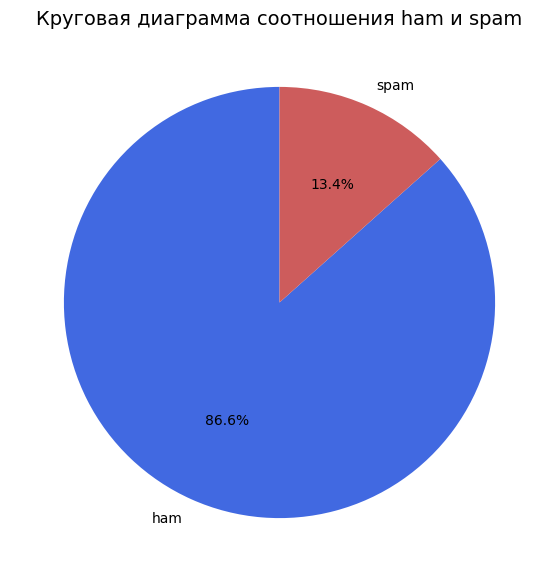

In [50]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.pie(df['Class'].value_counts(), labels=['ham', 'spam'], colors=['royalblue', 'indianred'], autopct='%1.1f%%', startangle=90)
ax.set_title(f'Круговая диаграмма соотношения ham и spam', fontsize=14)

## Стемминг и формирование корпуса

In [51]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
X = df.drop('Class', axis=1)
y = df['Class']
mail = df.copy()

In [53]:
ps = PorterStemmer()

mail['Message'] = mail['Message'].fillna('')

corpus = []
for i in range(len(mail)):
    text = str(mail.iloc[i, mail.columns.get_loc("Message")])
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub("http\S+|www\S+|https\S+", " ", text)
    text = re.sub("[^\w\s]", " ", text)
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words("english")]
    text = " ".join(text)
    corpus.append(text)

In [64]:
one_hot_repair=[one_hot(word,800) for word in corpus]
max_length = max(len(item) for item in one_hot_repair)

print(max_length)

77


##Текст после отступов

In [66]:
max_length
embedding_docs=pad_sequences(one_hot_repair,padding="pre",maxlen=max_length)
embedding_docs[:4]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0, 601, 376, 137, 529,
        782, 105, 450, 309, 190, 123, 424, 714, 234, 129, 742, 182],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 730, 695, 335, 556, 685, 209],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [67]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y[:4]

array([0, 0, 1, 0])

##Рекурентная нейросеть LSTM

In [71]:
embedding_vector_features = 32

model = Sequential()

model.add(Embedding(800, embedding_vector_features))

model.add(LSTM(64))

model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Коллбэки для предотвращения переобучения
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [72]:
X_final=np.array(embedding_docs)
y_final=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=42, shuffle = True)

In [73]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=10, batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.8523 - loss: 0.3913 - val_accuracy: 0.9677 - val_loss: 0.1268 - learning_rate: 0.0010
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9726 - loss: 0.0935 - val_accuracy: 0.9785 - val_loss: 0.0728 - learning_rate: 0.0010
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9884 - loss: 0.0395 - val_accuracy: 0.9821 - val_loss: 0.0723 - learning_rate: 0.0010
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9919 - loss: 0.0304 - val_accuracy: 0.9813 - val_loss: 0.0754 - learning_rate: 0.0010
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9921 - loss: 0.0274 - val_accuracy: 0.9821 - val_loss: 0.0749 - learning_rate: 0.0010
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9960 - loss: 0.0155 - val_accuracy: 0.9835 - val_loss: 0.0741 - learning_rate: 2.0000e-04
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9971 - l

<Axes: >

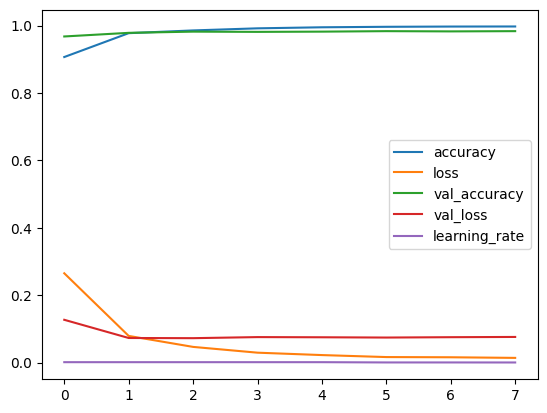

In [74]:
df2=pd.DataFrame(model.history.history)
df2.plot()

##Качество предсказаний

In [77]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


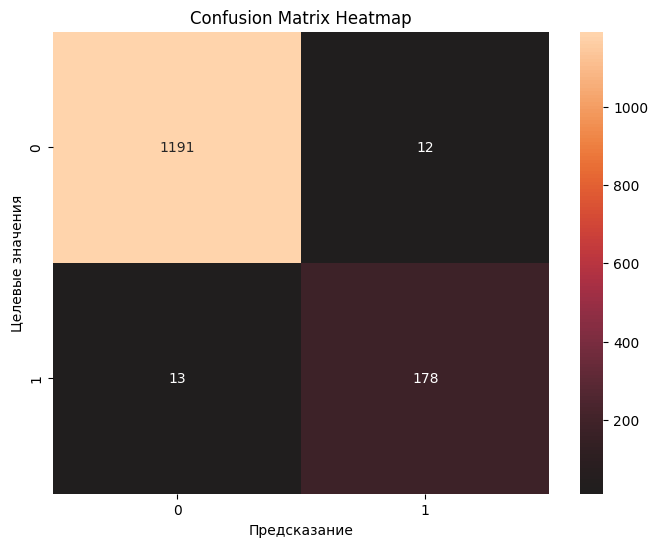

In [80]:
CM=confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(CM, annot=True, fmt='d', center=0)

plt.xlabel('Предсказание')
plt.ylabel('Целевые значения')
plt.title('Confusion Matrix Heatmap')

plt.show()

In [82]:
predictions = model.predict(X_test)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9801 - loss: 0.0673
Test Accuracy: 0.9820659756660461


Качество accuracy практически не падает в предсказаниях модели после валидации

## Проверка на новых данных

In [83]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=800)
tokenizer.fit_on_texts(corpus)

stemmer = PorterStemmer()

def preprocess_text(input_text):
    text = re.sub("[^a-zA-Z]", " ", input_text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords.words("english")]
    text = " ".join(text)
    return text

def predict_spam(input_text):
    processed_text = preprocess_text(input_text)

    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=47)

    prediction = model.predict(padded_sequence)

    if prediction > 0.5:
        return "Not Spam"
    else:
        return "Spam"

In [85]:
new_message = "Resend this letter to your friends!"
result = predict_spam(new_message)
print(f"The message is: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The message is: Spam


Результат положительный, модель верно определяет спам.